In [1]:
#import packages
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from functools import reduce
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

#initiate data paths, using Path insures paths can be replicated on any OS
clean_data_fpath = Path("Data/clean")
final_data_fpath = Path("Data/final")

# Read in Clean Data

In [2]:
filename = 'accepted_2007_to_2018Q4cleaned'
accepted_df = pd.read_csv(clean_data_fpath / (filename + '.csv'), \
                          parse_dates = ['issue_d', 'earliest_cr_line', 'last_pymnt_d','next_pymnt_d',
                                         'last_credit_pull_d'], infer_datetime_format = True,low_memory=False, 
                                          index_col = 'id')
accepted_df.head()

/Users/peterkromkowski/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
id,,,,,,,,,,,,,,,,,,,,,
68407277,NaN,3600.0,3600.0,3600.0,36.0,13.99,123.03,C,C4,leadman,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
68355089,NaN,24700.0,24700.0,24700.0,36.0,11.99,820.28,C,C1,Engineer,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
68341763,NaN,20000.0,20000.0,20000.0,60.0,10.78,432.66,B,B4,truck driver,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
66310712,NaN,35000.0,35000.0,35000.0,60.0,14.85,829.90,C,C5,Information Systems Officer,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
68476807,NaN,10400.0,10400.0,10400.0,60.0,22.45,289.91,F,F1,Contract Specialist,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print(accepted_df.dtypes)

member_id                float64
loan_amnt                float64
funded_amnt              float64
funded_amnt_inv          float64
term                     float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 150, dtype: object


# Problem Statement

The data contains a lot of information that could be useful to analyze multiple relationships and patterns. With more time, a specific purpose statement, and a client's goal in mind, analysis of all columns should be completed. For the sake of this project, I aim to identify the 20 most important variables and load them into my clean datatable. This will reduce the size of the dataset and provide a helpful starting point for further analysis.

In the future, proper vetting should include studying look ahead bias, correcting data imputations errors, analyzing selection bias, and outlier detection.  

In [4]:
dtf = accepted_df.copy()

## Missing Values

The percent of missing values for each feature was calculated and the sorted list was graphed. After ~40% missing values in a feature, there is a steep spike in missing data per feature and an eventual plateau at ~95% missing. 

The many plateaus with similar amounts of missing values supports a hypothesis proposed during cleaning: that groups of features were added together at a specific point in time. If these features are left in, models may accidentally create a strong relationship between the year, if a specific feature is present during that year, and performance. 

The features with more than 40% missing were removed to keep all the features up to and including the second plateau. If more detailed information on each feature and the data imputation process from Lending Club were known, we could impute the missing values with cluster means or other data filling processes and use a less conservative threshold.  

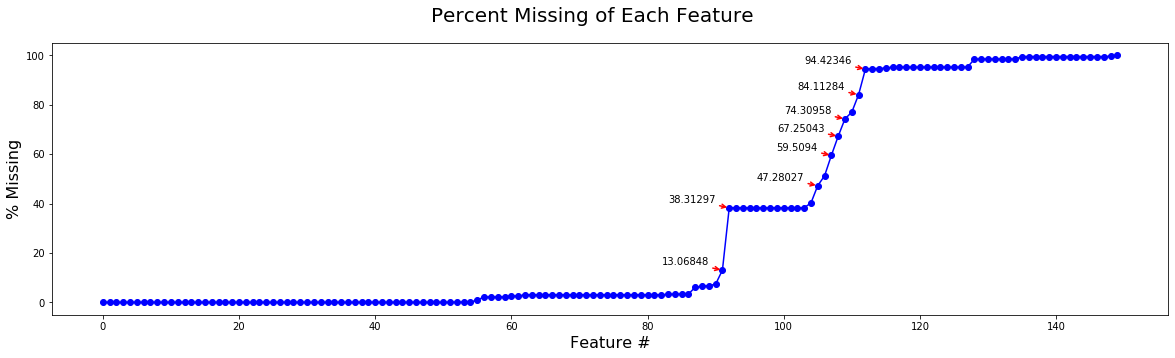

In [5]:
#Function for placing labels at kinks on the graph
def label_kink_missing(data, ax):
    if data['percent'] - data['prev'] > 5:
            ax.annotate(str(round(data['percent'], 5)),xy=(data['index'], data['percent'])\
            ,xytext=(data['index']-2, data['percent']+2),ha='right',
            arrowprops=dict(arrowstyle="->", color='r', lw=1.5, connectionstyle="arc3"))

#Get percent of each feature that is missing
percent_missing = sorted(dtf.isnull().sum() * 100 / len(dtf))
missing = pd.DataFrame(percent_missing, columns = ['percent'])
missing['prev'] = missing['percent'].shift(1)
missing['index'] = missing.index

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(missing['percent'],'bo-')
ax.set_ylabel("% Missing", fontsize = 16)
ax.set_xlabel("Feature #", fontsize = 16)
missing.apply(lambda x: label_kink_missing(x, ax = ax), axis = 1)
plt.suptitle('Percent Missing of Each Feature', fontsize = 20)
plt.show()

In [6]:
#select columns with less than 40 percent missing rows
dtf = dtf[dtf.columns[dtf.isnull().mean() <= 0.40]]

## Datetime Columns

In [7]:
dtf_date = dtf.select_dtypes(include='datetime64[ns]')

All of the datetime features provide unique information and distributions so all of them were kept. The similar spike in credit pull dates and last payment dates recently should be further researched to understand the relationship between the two and confidence in the data collection process of both of them.

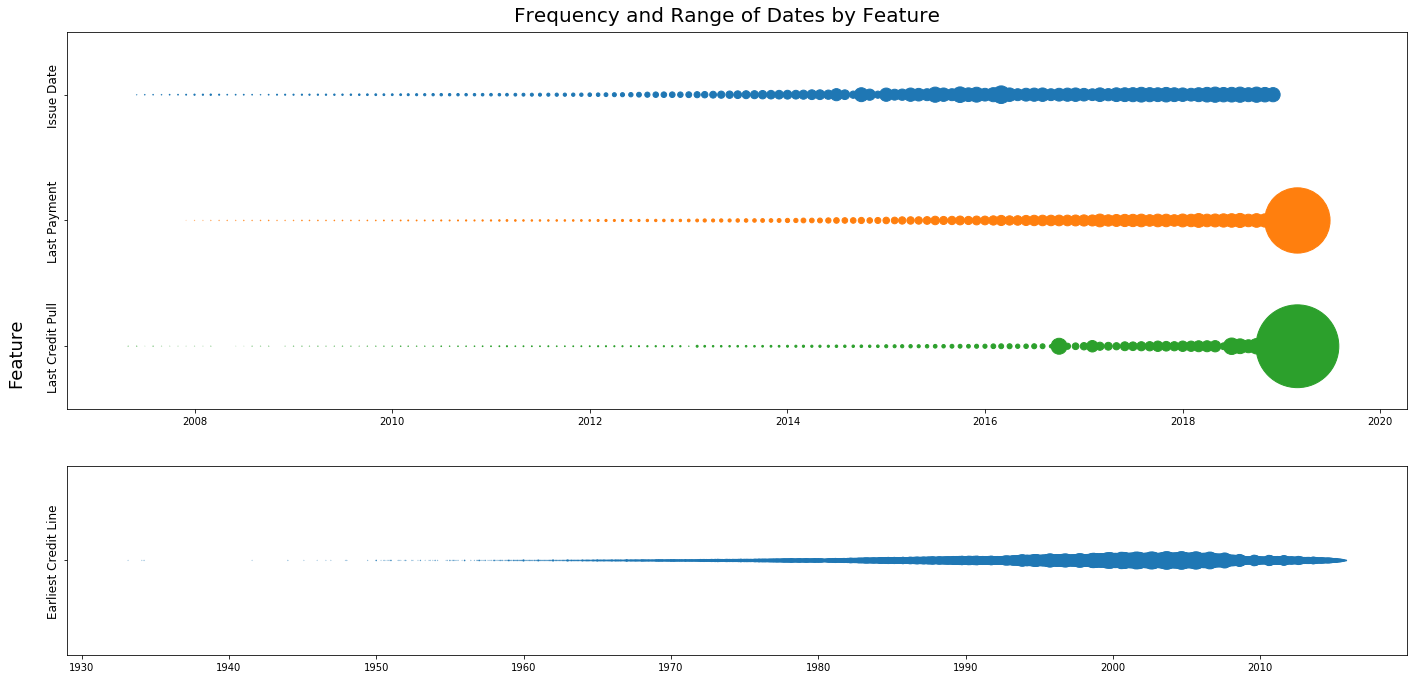

In [8]:
df = pd.DataFrame(index=pd.unique(dtf_date[['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']]\
                                      .values.ravel('K'))).sort_index()
# create a (constant) series for each feature
df['earliest_cr_line'] = df.index.to_series().apply(lambda x: 4 if x >= dtf_date['earliest_cr_line'].min() and \
                                                    x <= dtf_date['earliest_cr_line'].max() else np.NaN)
df['issue_d'] = df.index.to_series().apply(lambda x: 3 if x >= dtf_date['issue_d'].min() and \
                                           x <= dtf_date['issue_d'].max() else np.NaN)
df['last_pymnt_d'] = df.index.to_series().apply(lambda x: 2 if x >= dtf_date['last_pymnt_d'].min() and \
                                                x <= dtf_date['last_pymnt_d'].max() else np.NaN)
df['last_credit_pull_d'] = df.index.to_series().apply(lambda x: 1 if x >= dtf_date['last_credit_pull_d'].min() and \
                                                      x <= dtf_date['last_credit_pull_d'].max() else np.NaN)

# create a frequency series per date for each feature
df['earliest_cr_line_freq'] = dtf_date['earliest_cr_line'].value_counts()
df['issue_d_freq'] = dtf_date['issue_d'].value_counts()
df['last_pymnt_d_freq'] = dtf_date['last_pymnt_d'].value_counts()
df['last_credit_pull_d_freq'] = dtf_date['last_credit_pull_d'].value_counts()

#plot
fig, ax = plt.subplots(2, 1, figsize=(20,10), gridspec_kw={'height_ratios': [2,1]})
fig.text(0,.5, 'Feature', va = 'center', rotation = 90, fontsize = 18)
ax[0].scatter(x = df.index,y = df['issue_d'], s = df['issue_d_freq']/200)
ax[0].scatter(x = df.index,y = df['last_pymnt_d'], s = df['last_pymnt_d_freq']/200)
ax[0].scatter(x = df.index,y = df['last_credit_pull_d'], s = df['last_credit_pull_d_freq']/200)
ax[1].scatter(x = df.index,y = df['earliest_cr_line'], s = df['earliest_cr_line_freq']/50)

#Set x axis
plt.setp(ax[0].get_xticklabels(), rotation=0, horizontalalignment='center')
plt.setp(ax[1].get_xticklabels(), rotation=0, horizontalalignment='center')
#Set y axis
ax[0].set_ylim([.5, 3.5])
ax[0].set_ylim=[3.5, 4.5]
ax[0].set_yticks([1, 2, 3])
ax[1].set_yticks([4])
ax[0].set_yticklabels(['Last Credit Pull','Last Payment','Issue Date'], fontsize = 12, rotation = 90, va='center')
ax[1].set_yticklabels(['Earliest Credit Line'], fontsize = 12, rotation = 90, va='center')

plt.tight_layout(pad=4.0)
plt.suptitle("Frequency and Range of Dates by Feature", fontsize = 20)
plt.show()

## Object Columns

In [9]:
#subset dataset with just object columns to perform feature selection that only applies to categorical data
dtf_obs =  dtf.select_dtypes(include='object')

### Correlation 

From initial feature exploration and the description of the features, it is suspected that some features have a derivative nature with others. Correlated pairs may stop an algorithm from detecting other patterns and overweight the effect of the correlated pair because it, effectively, appears twice in the dataset. Therefore, one feature from each correlated pair was removed. 

This graph displays the distributions for the features that relate to loan grading and loan purpose. The distributions are identical in each pair. The 'grade' feature was removed because it can be derived from 'sub_grade' if needed. Likewise, 'title' was also removed for its similarity to 'purpose'. In the future, text cleaning and analysis should be completed to combine like terms in title. A smaller dimension of data could provide unique information that is either not present in 'purpose' or labeled as "other".

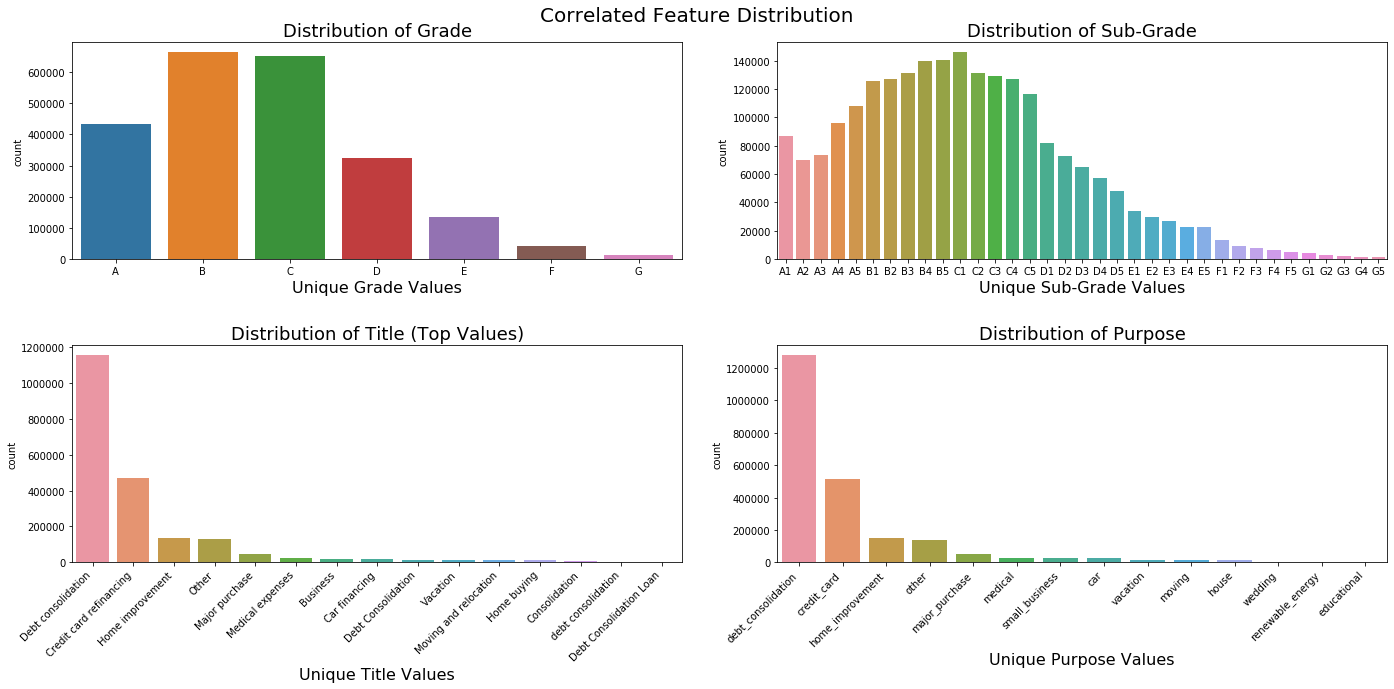

In [10]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

sns.countplot(dtf_obs['grade'], order = sorted(dtf_obs['grade'].unique()), ax=ax[0,0])
sns.countplot(dtf_obs['sub_grade'], order = sorted(dtf_obs['sub_grade'].unique()), ax=ax[0,1])
ax[0,0].set_title('Distribution of Grade', fontsize=18)
ax[0,1].set_title('Distribution of Sub-Grade', fontsize=18)
ax[0,0].set_xlabel("Unique Grade Values", fontsize = 16)
ax[0,1].set_xlabel("Unique Sub-Grade Values", fontsize = 16)

#plot the frequency table of unique values for each feature
sns.barplot(x= dtf['title'].value_counts().to_frame("count").reset_index().iloc[0:15]['index'], \
            y=dtf['title'].value_counts().to_frame("count").reset_index().iloc[0:15]['count'], ax = ax[1,0])
sns.barplot(x= dtf['purpose'].value_counts().to_frame("count").reset_index()['index'], \
            y=dtf['purpose'].value_counts().to_frame("count").reset_index()['count'], ax = ax[1,1])
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=45, horizontalalignment='right') #so xlabels dont overlap
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[1,0].set_title('Distribution of Title (Top Values)', fontsize=18)
ax[1,1].set_title('Distribution of Purpose', fontsize=18)
ax[1,0].set_xlabel("Unique Title Values", fontsize = 16)
ax[1,1].set_xlabel("Unique Purpose Values", fontsize = 16)

plt.tight_layout(pad=3.0) #a lot of information in with 4 subplots, add some extra space between plots
plt.suptitle('Correlated Feature Distribution', fontsize=20)
plt.show()

In [11]:
#drop correlated columns
dtf_obs.drop(['grade','title'], axis = 1,inplace = True, errors = 'ignore')

/Users/peterkromkowski/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Factor Levels & Class Imbalance

If a column has too many unique values it will be impossible to extrabolate any patterns, correlations, or causations from the data because the variability will be too high. Similarly, if a feature has high class imbalance, even with proper precaution and corrective sampling, it may produce analysis with poor predictive power or severe bias. 

This graph displays the break-down of frequencies for each feature. If a feature has 1000+ unique values the distributions become homogeneous and relationships cannot be extracted. Features with greater than 1000 unique values were removed.

This graph also displays the severe class imbalance of 5 features ('debt_settlement_flag','disbursement_method','hardship_flag','application_type','pymnt_plan'). These class imbalances are very strong and may make these features useless in further analysis so they are removed. 'initial_list_status' may have a strong enough distribution to sample out its imbalance, using techniques such as SMOTE, so it is kept in the dataset for now.

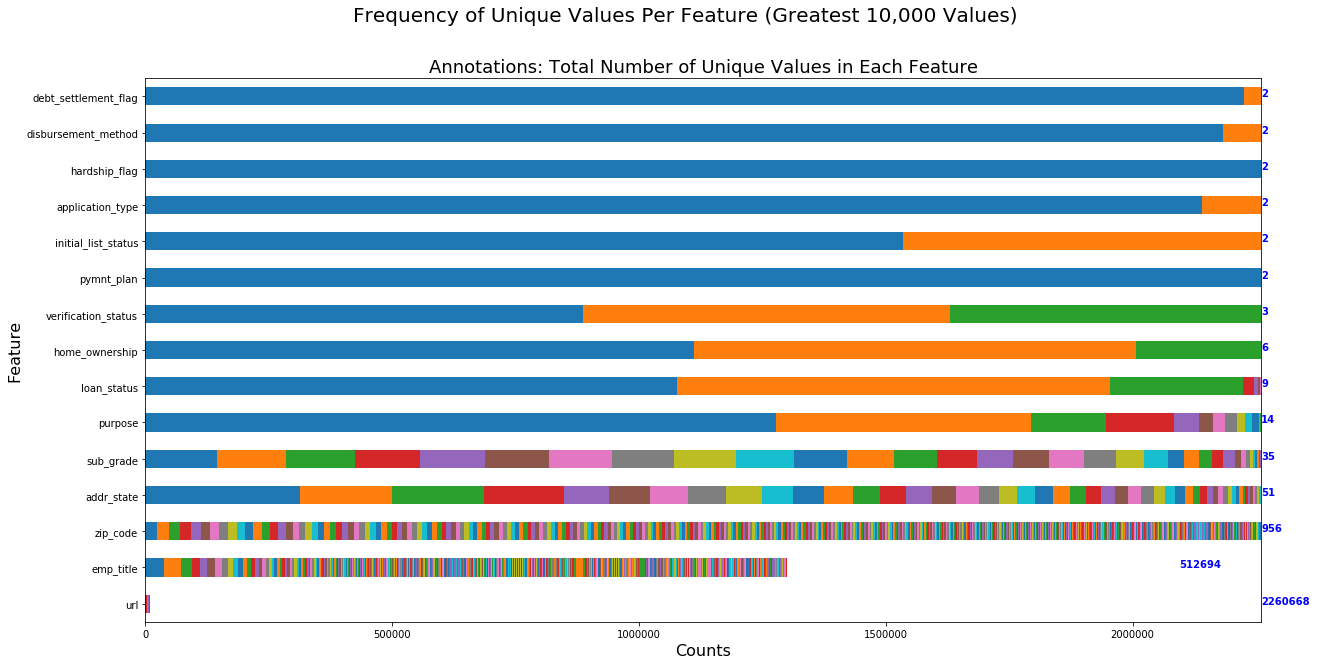

In [12]:
#Create a dataframe of unique counts for each value in each feature (multiindex frequency table)
freq_dict = {col: pd.Series(dtf_obs[col].value_counts().to_list()) for col in dtf_obs}
#features names are transposed to the index because barplot stackes horizontally, not columns wise  
freq_df = pd.DataFrame(freq_dict).T 
#Calculate total number of uniq values per feature and total number of observations (only used for annotations)
num_uniq = freq_df.count(axis=1)
totals = freq_df.sum(axis = 1)
freq_df['NUnique'] = num_uniq
freq_df['Total'] = totals
freq_df.sort_values(by=['NUnique'], inplace = True, ascending=False)

#plot stacked barchart for each feature
fig, ax = plt.subplots(figsize=(20,10))
# two features have too many unique values to make a stacked bar graph efficient, 
# instead plot at most 10,000 most frequent values for each feature 
# (1000 is only needed to get the full scope of 13 features) 
freq_df.iloc[:, 0:10000].plot(kind="barh", stacked=True, ax=ax)
#use iloc becuase row wise and the frequecny of popular values for each feature are sorted horizontally left to right 
ax.get_legend().remove()
ax.set_ylabel("Feature", fontsize=16)
ax.set_xlabel("Counts", fontsize=16)
ax.set_title('Annotations: Total Number of Unique Values in Each Feature', fontsize=18)
for text, height, i in zip(freq_df['NUnique'], freq_df['Total'], list(range(0, len(freq_df)))):
    ax.text(height + 100, i, text, color='blue', fontweight='bold')
plt.suptitle('Frequency of Unique Values Per Feature (Greatest 10,000 Values)', fontsize=20)
plt.show()

In [13]:
#drop columns with a factor level greater than 1000
dtf_obs.drop([c for c in dtf_obs.columns if dtf_obs[c].nunique() > 1000],axis=1, inplace = True)
#drop columns with class imbalance
dtf_obs.drop(['debt_settlement_flag','disbursement_method','hardship_flag','application_type','pymnt_plan'] \
             , axis = 1, inplace = True)

### Ambiguous Columns

There are some ambiguous object columns that were removed because they did not contain any unique information or because the description for the feature in the data dictionary was unclear. The features that fit this criteria are:

- zipcode: the last two digits are removed so the original zip codes cannot be uniquely identified. With the addr_state feature, some reverse engineering could be used to identify the specific region each zip code could possibly belong to, but zip codes are rather arbitrary and this would not provide any greater information than the addr_state feature already does.

- verification_status: the description, "Indicates if income was verified by LC, not verified, or if the income source was verified", is unclear and does not provide details on possible overlapping values. Lending Club requires documents and verification so the difference between verified and not verified is unclear.

- initial_list_status: the description is "The initial listing status of the loan. Possible values are – W, F," but the values of W and F are not provided

In [14]:
#drop ambiguous columns
dtf_obs.drop(['zip_code','verification_status','initial_list_status'], axis = 1,inplace = True)

## Numeric Columns

In [15]:
#subset dataset with just numeric columns to perform feature selection that only applies to numeric data. 
#data is only 'float64' but capture anything that was looked over
dtf_float = dtf.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
#The tests for feature selection require the data to be scaled
X = MinMaxScaler().fit_transform(dtf_float.values) #scale each feature independetly [0,1]
dtf_float = pd.DataFrame(X, index=dtf_float.index, columns=dtf_float.columns)

### Variance Threshold

If the variance is low or close to zero, then a feature is approximately constant and will not improve the performance of the model. Worse, low variance can distract the algorithm, especially those which are distance based.

Normally, to build a model, a grid search of arbitrary variance thresholds and their affect on prediction performance can be used to pick the optimal variance threshold. In this instance, a kinked graph was created based on the sorted variances of each feature. Because there are no specifications for what this data will be used for or a known client risk appetite, the optimal variance was conservatively chosen.

This graph displays the sorted variances for each feature. It highlights kinks in the graph where the data is greater than the previous feature by .001. The first kink, .007, was chosen as the variance threshold.

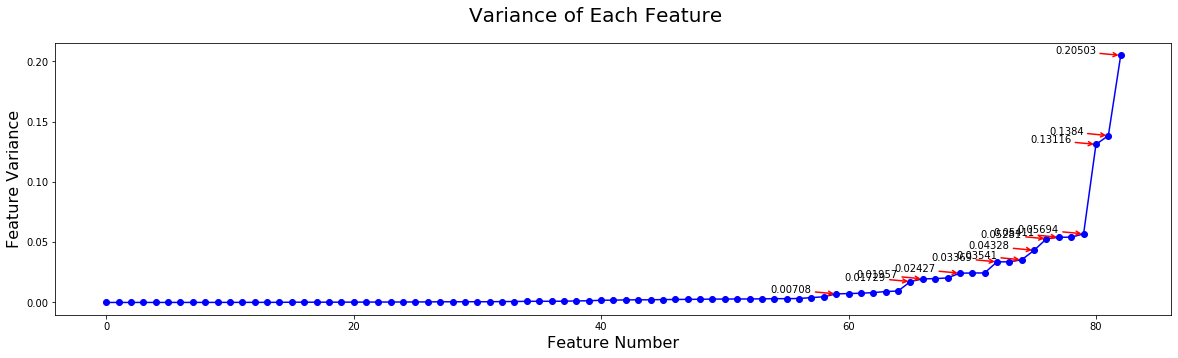

In [16]:
#Function for placing labels at kinks on the graph
def label_kink_var(data, ax):
    if data['variance'] - data['prev'] > .001:
            ax.annotate(str(round(data['variance'], 5)),xy=(data['index'], data['variance']),\
                        xytext=(data['index']-2, data['variance']+.001),ha='right',\
                        arrowprops=dict(arrowstyle="->", color='r', lw=1.5,connectionstyle="arc3"))

#calculate variance for each feature and sort
loan_var = sorted(dtf_float.var())
var = pd.DataFrame(loan_var, columns = ['variance'])
#get variance for feature that one less than (in position) than current feature
var['prev'] = var['variance'].shift(1)
var['index'] = var.index


fig, ax = plt.subplots(figsize=(20,5))
ax.plot(loan_var,'bo-')
ax.set_ylabel("Feature Variance", fontsize=16)
ax.set_xlabel("Feature Number", fontsize=16)
var.apply(lambda x: label_kink_var(x, ax = ax), axis = 1)
plt.suptitle('Variance of Each Feature', fontsize=20)
plt.show()

In [17]:
thresholder = VarianceThreshold(threshold=.01729)
thresholder.fit(dtf_float)
float_var_cols = dtf_float.columns[thresholder.get_support(indices=True)]
dtf_float = dtf_float[float_var_cols]

### Correlation  Testing

Correlation coefficients are used to assess the strength and direction of the linear relationships between pairs of features. In an effort to reduce the variance when modeling, correlated pairs are broken up. 

A heat-map correlation matrix was created to identify highly correlated groups. These groups were then extracted and graphed on distribution plots to visualize how truly correlated the groups were. 

All groups show intercorrelation and relatively the same densities. One column from each group was selected or a summarizing column was created to capture the patterns in the data. The chosen default column in each group was the column that is directly related to the investors on Lending Club ('_inv') becuase they are tied more closely with the other features and overall process, and don't contain information that is completely unexplainable.

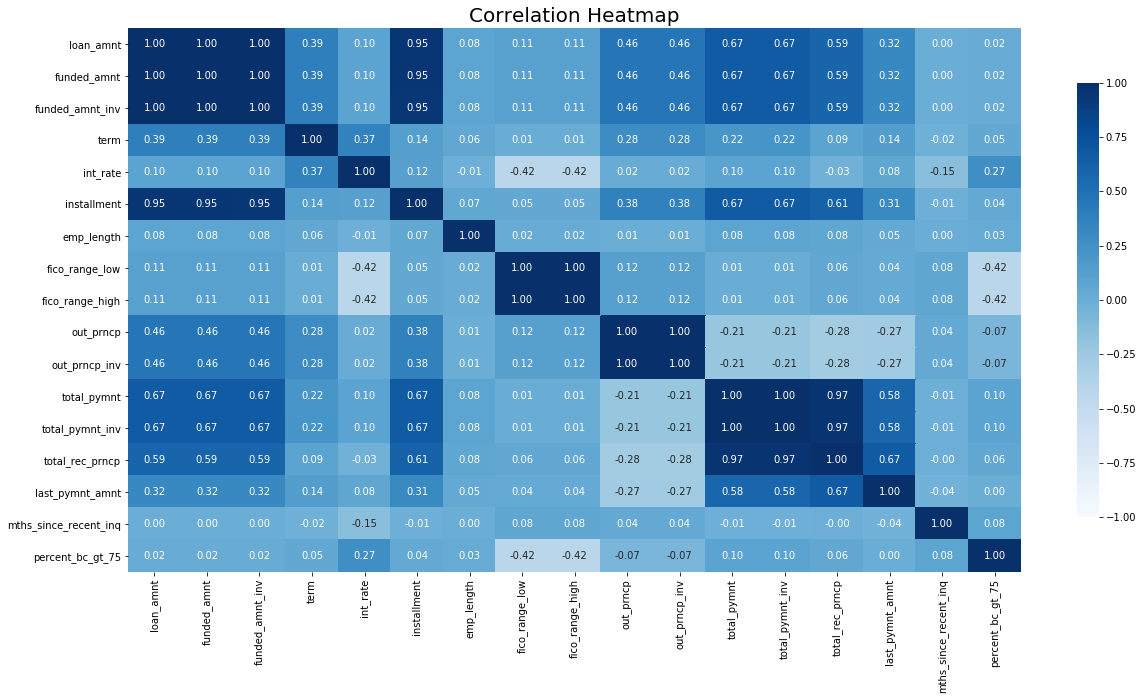

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
loan_corr = dtf_float.corr() #create correlation matrix for all column to column pairs
sns.heatmap(loan_corr, annot=True, fmt=".2f", cmap='Blues', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
#.corr() creats a matrix, and sns.heatmap creates a better visualization of the matrix
plt.title("Correlation Heatmap", fontsize = 20)
plt.show()

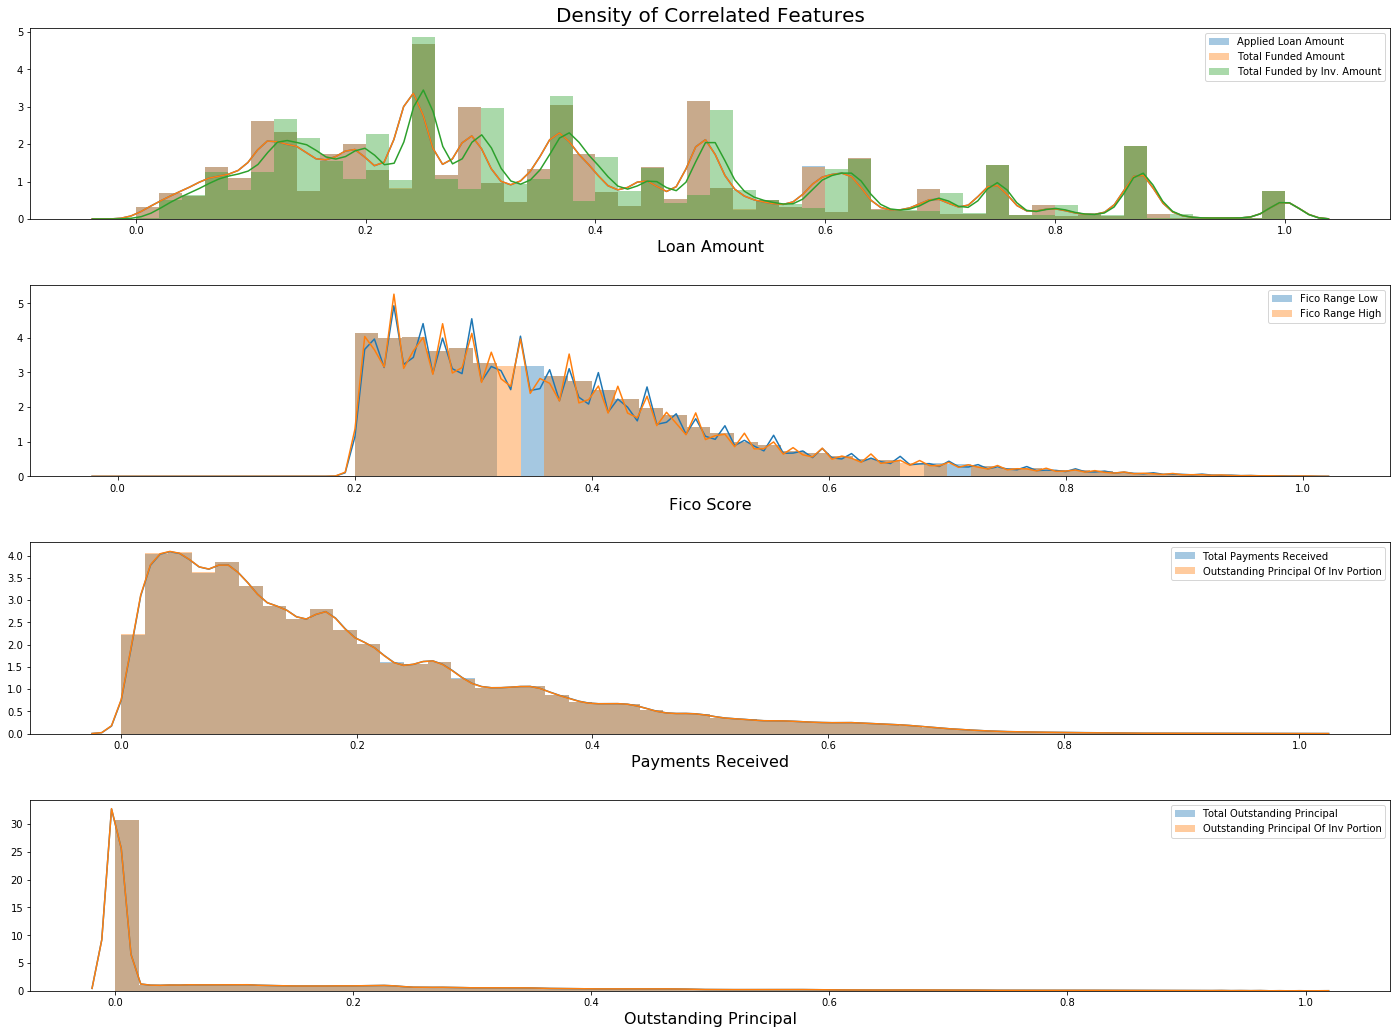

In [19]:
fig, ax = plt.subplots(4,1,figsize=(20,15))

#Loan Amounts
labels1 = ['Applied Loan Amount', 'Total Funded Amount', 'Total Funded by Inv. Amount']
sns.distplot(dtf_float['loan_amnt'], label=labels1[0], ax = ax[0])
sns.distplot(dtf_float['funded_amnt'], label=labels1[1], ax = ax[0])
sns.distplot(dtf_float['funded_amnt_inv'], label=labels1[2], ax = ax[0])
ax[0].set_xlabel("Loan Amount", fontsize = 16)
ax[0].set_title('Density of Correlated Features', fontsize=20)
ax[0].legend()
    
#Fico Range
labels2 = ['Fico Range Low', 'Fico Range High']
sns.distplot(dtf_float['fico_range_low'], label=labels2[0], ax = ax[1])
sns.distplot(dtf_float['fico_range_high'], label=labels2[1], ax = ax[1])
ax[1].set_xlabel("Fico Score", fontsize = 16)
ax[1].legend()

#Total Payment
labels3 = ['Total Payments Received', 'Outstanding Principal Of Inv Portion']
sns.distplot(dtf_float['total_pymnt'], label=labels3[0], ax = ax[2])
sns.distplot(dtf_float['total_pymnt_inv'], label=labels3[1], ax = ax[2])
ax[2].set_xlabel("Payments Received", fontsize = 16)
ax[2].legend()

#Outstanding Principal
labels3 = ['Total Outstanding Principal', 'Outstanding Principal Of Inv Portion']
sns.distplot(dtf_float['out_prncp'], label=labels3[0], ax = ax[3])
sns.distplot(dtf_float['out_prncp_inv'], label=labels3[1], ax = ax[3])
ax[3].set_xlabel("Outstanding Principal", fontsize = 16)
ax[3].legend()


plt.tight_layout(pad=3.0)
plt.show()

In [20]:
#get current column names after performing variance threshold 
scaled_var_cols = dtf_float.columns
# Edit actual dataset and not scaled dataset
dtf_float = dtf.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
# subset of numeric columns that were present after performing variance threshold
dtf_float = dtf_float[scaled_var_cols]

#mean fico scores by averaging low and high
dtf_float['mean_fico'] = (dtf_float['fico_range_low'] + dtf_float['fico_range_high'])/2

#drop correlated features
dtf_float.drop(['loan_amnt','funded_amnt','total_pymnt','out_prncp','fico_range_low','fico_range_high', \
                ], axis = 1, inplace = True)

#Installment is just the monthly payment of the loan balance, interest rate, and term length. 
#Dropping, can be recalculated if necessary
dtf_float.drop('installment', axis = 1, inplace = True)

# The sum of 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee' (removed earlier) is ~total_pymnt. 
# The total payment feature generally captures the total relationship well, so these features are removed
dtf_float.drop(['total_rec_prncp'] , axis = 1, inplace = True)

## Final Dataset

The top 20 features (including the index) in the Lending Club Accepted-Dataset have been extracted and can be exported to a main csv or datatable. The remaining columns are saved and exported to a seperate location for later use if necessary. They can be joined using the 'id' index.

In [21]:
dfs = [dtf_float, dtf_obs, dtf_date]
accepted_df_main = reduce(lambda left,right: left.join(right,how='outer'), dfs)
accepted_df_secondary = accepted_df.drop(accepted_df_main.columns, axis=1, errors='ignore')
print(accepted_df_main.columns)

Index(['funded_amnt_inv', 'term', 'int_rate', 'emp_length', 'out_prncp_inv',
       'total_pymnt_inv', 'last_pymnt_amnt', 'mths_since_recent_inq',
       'percent_bc_gt_75', 'mean_fico', 'sub_grade', 'home_ownership',
       'loan_status', 'purpose', 'addr_state', 'issue_d', 'earliest_cr_line',
       'last_pymnt_d', 'last_credit_pull_d'],
      dtype='object')


In [22]:
accepted_df_main.to_csv(final_data_fpath / 'accepted_df_main.csv', index = True)
accepted_df_secondary.to_csv(final_data_fpath / 'accepted_df_secondary.csv', index = True)

# Final Thoughts

This Lending Club dataset is an extensive and large dataset that could be capable of providing valuable insights into the activity that is done through Lending Club, and as a proxy for the loan market as a whole. For example, investors may be interested in what loans being sold on the secondary market, after being accepted, have a high chance of defaulting. With this EDA process, a dataset of just 20, strong, and independent, variables was able to be created. This smaller dataset saves on storage space, query times, and aggregation functions. But most importantly, it reduces a lot of noise that was initially present so that clear patterns and relationships can be extracted to support model development and hypothesis formation. 

It is clear that this may not be the best dataset for every problem. Some problems may need the removal of columns that contain information that is in the future of what they are trying to predict. Other problems may be focused on just one part of the application process, such as secondary applicant statistics. But this process can be used to reduce the feature space for any problem and give the modeler a sense of how strong the subset of data they are working on is. 